## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Helpers

In [1]:
def region_of_interest(img, vertices):
    """
    Region of interest masking from P1
    
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image




## Camera Calibration

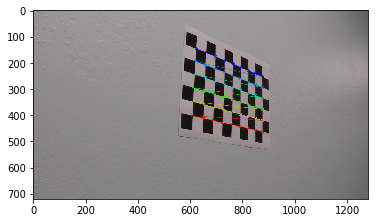

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

# calculate the camera calibration from object and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

## Distortion Correction

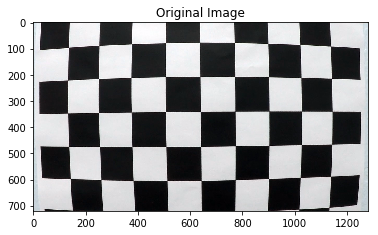

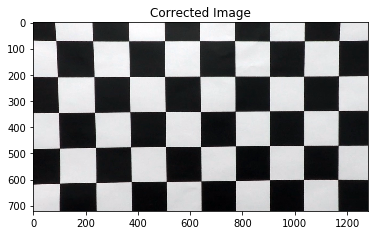

In [3]:
img = cv2.imread(images[0])
dst = cv2.undistort(img, mtx, dist, None, None)

%matplotlib inline

plt.imshow(img)
plt.title('Original Image')
plt.figure()
plt.imshow(dst)
plt.title('Corrected Image')

## Binary Image

In [4]:
def combined_bin(img):
    
    # undistort image
    img = cv2.undistort(img, mtx, dist, None, None)
    
    # convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    out = np.zeros_like(img[:,:,2])
    out[(grad_im(img) == 1) | (color_im(hls) == 1)] = 1
    return out


def grad_im(img):
    
    # grayscaling
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel_x = scale_im(abs_sobelx)
    
    # Sobel y
    sobely = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel_y = scale_im(abs_sobely)
    
    # Threshold x gradient
    sxbinary = binary_im(scaled_sobel_x, [40, 100])
    
    # Threshold y gradient
    sybinary = binary_im(scaled_sobel_y, [30, 100])

    # gradient magnitude
    mag_ksize = 5
    mag_threshs = [35, 100]
    mag_binary = mag_thresh(gray, mag_ksize, mag_threshs)
    
    # gradient direction
    dir_ksize = 15
    dir_threshs = [0.7, 1.3]
    dir_binary = dir_threshold(gray, dir_ksize, dir_threshs)
    
    combined = np.zeros_like(dir_binary)
    combined[((sxbinary == 1) & (sybinary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined


def binary_im(img, threshs):
    
    # return binary image showing where pixel values are between thresholds
    out = np.zeros_like(img)
    out[(img >= threshs[0]) & (img <= threshs[1])] = 1
    
    return out


def scale_im(img):
    
    # normalize image
    return np.uint8(255*img/np.max(img))


def mag_thresh(gray, sobel_kernel=3, mag_threshs=(0, 255)):
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude und scale to 8 bit
    gradmag = scale_im(np.sqrt(sobelx**2 + sobely**2))
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_threshs[0]) & (gradmag <= mag_threshs[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


def color_im(hls):
    
    # extract S channel
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    return s_binary

image shape:
(720, 1280, 3)


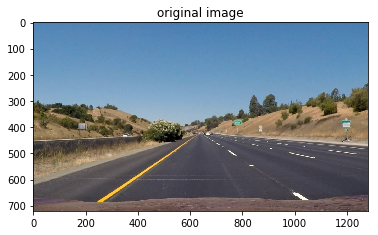

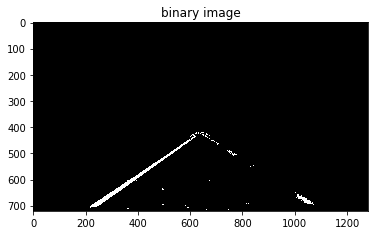

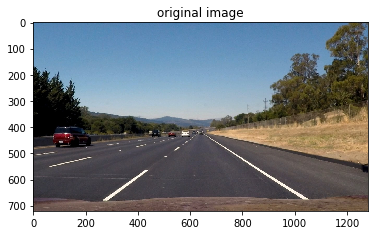

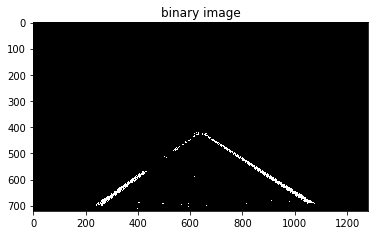

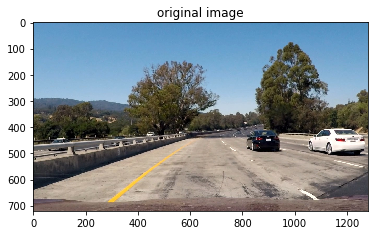

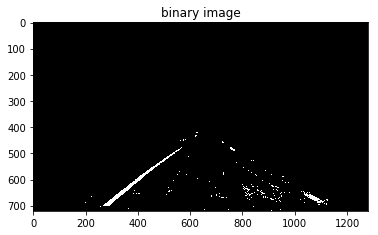

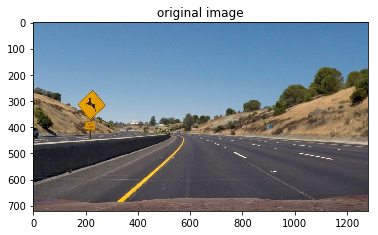

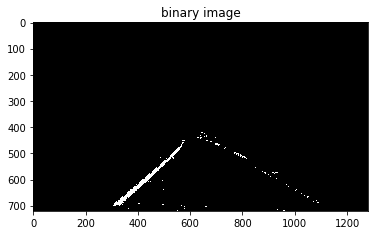

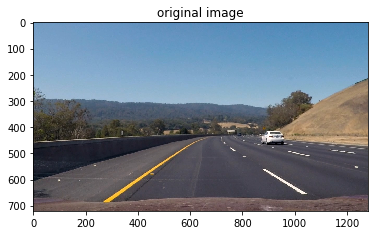

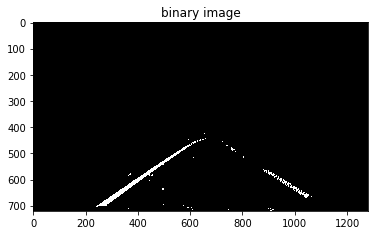

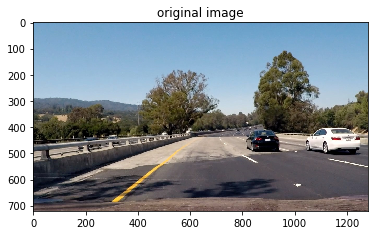

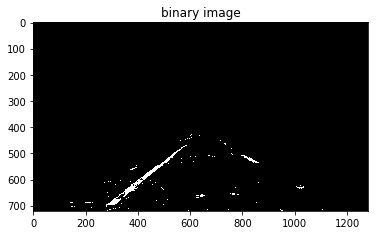

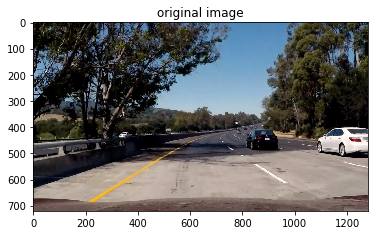

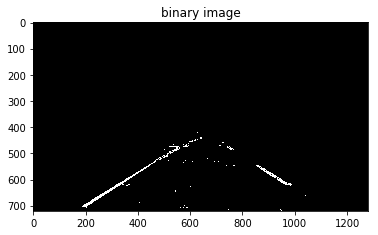

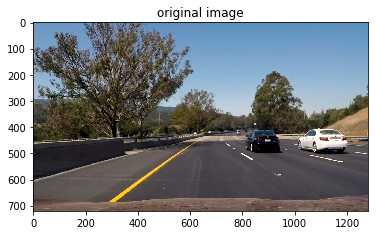

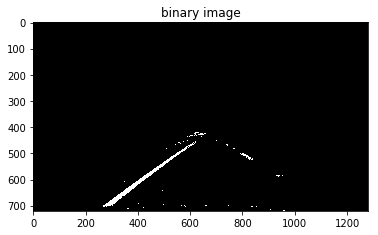

In [5]:
# region of interest
imshape = img.shape;
vertices = np.array([[(75,imshape[0]),(620, 420), (660, 420), (imshape[1]-75,imshape[0])]], dtype=np.int32)

print('image shape:')
print(imshape)

road_images = glob.glob('./test_images/*.jpg')

for i in range(len(road_images)):
    img = cv2.imread(road_images[i])[:,:,::-1]
    plt.figure()
    plt.imshow(img)
    plt.title('original image')
    plt.figure()
    plt.imshow(region_of_interest(combined_bin(img), vertices), cmap = 'gray')
    plt.title('binary image')

## Perspective Transform

In [6]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped


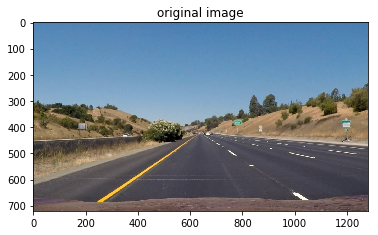

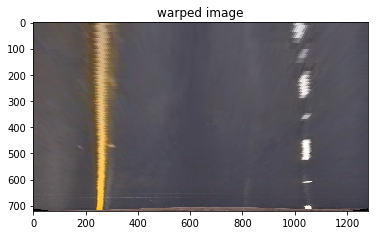

In [7]:
img_size = (img.shape[1], img.shape[0])
ofs = 100

src = np.float32([(32,imshape[0]),(577, 450), (703, 450), (imshape[1]-32,imshape[0])])
dst = np.float32([[ofs, img_size[1]], [ofs, 0], [img_size[0]-ofs, 0], [img_size[0]-ofs, img_size[1]]])

img = cv2.imread(road_images[0])[:,:,::-1]
plt.imshow(img)
plt.title('original image')
plt.figure()
plt.imshow(warper(cv2.undistort(img, mtx, dist, None, None), src, dst))
plt.title('warped image')

## Lane Detection

In [8]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped_img, window_width, window_height, margin):
    
    w = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped_img[int(3*warped_img.shape[0]/4):,:int(warped_img.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped_img[int(3*warped_img.shape[0]/4):,int(warped_img.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    w.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped_img.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped_img[int(warped_img.shape[0]-(level+1)*window_height):int(warped_img.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped_img.shape[1]*0.66))
        l_conv = conv_signal[l_min_index:l_max_index]
        if max(l_conv > 10):
            l_center = np.argmax(l_conv)+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,warped_img.shape[1]*0.33))
        r_max_index = int(min(r_center+offset+margin,warped_img.shape[1]))
        r_conv = conv_signal[r_min_index:r_max_index]
        if max(r_conv > 10):
            r_center = np.argmax(r_conv)+r_min_index-offset
        # Add what we found for that layer
        w.append((l_center,r_center))

    return w

def lane_points(window_centroids, imshape, window_height):
    
    # calculate points for polyfit from window centroids
    left = [[c[0], imshape[0] - i * window_height - window_height/2] for i, c in enumerate(window_centroids)]
    right = [[c[1], imshape[0] - i * window_height - window_height/2] for i, c in enumerate(window_centroids)]
    
    return left, right

def fit_lanes(left_, right_):
    
    # split arrays
    leftx = [p[0] for p in left_]
    lefty = [p[1] for p in left_]
    rightx = [p[0] for p in right_]
    righty = [p[1] for p in right_]
    
    # fit polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

def get_plot_data(warped, left_fit, right_fit):
    # Generate x and y values for plotting
    y = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    lx = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    rx = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
    return lx, rx, y

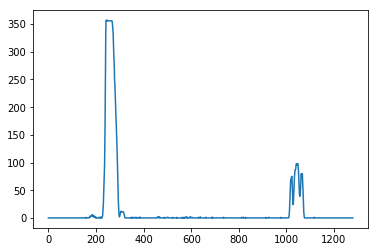

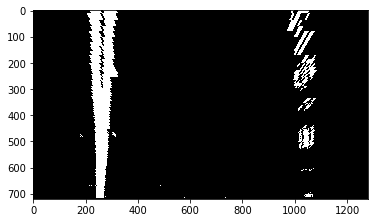

In [9]:
img = cv2.imread(road_images[0])[:,:,::-1]
processed_img = warper(region_of_interest(combined_bin(img), vertices), src, dst)
histogram = np.sum(processed_img[processed_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.figure()
plt.imshow(processed_img, cmap = 'gray')

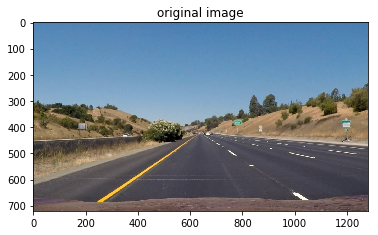

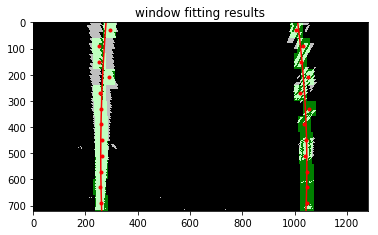

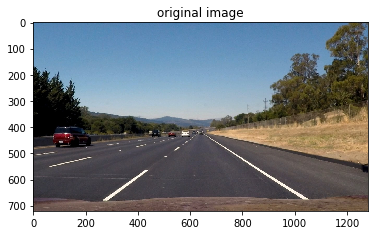

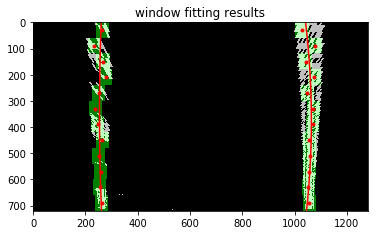

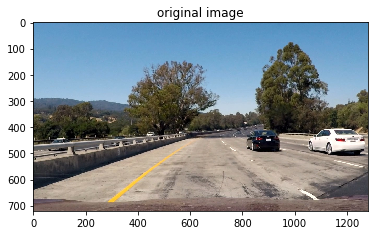

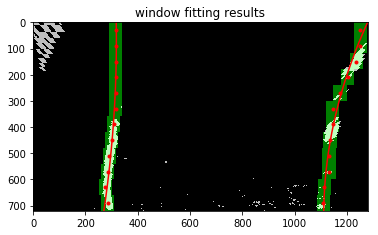

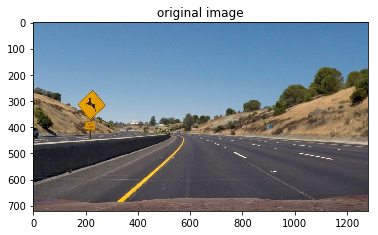

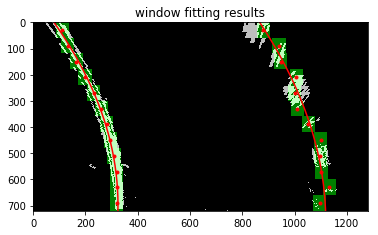

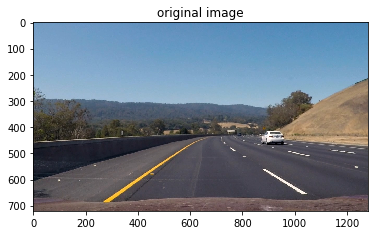

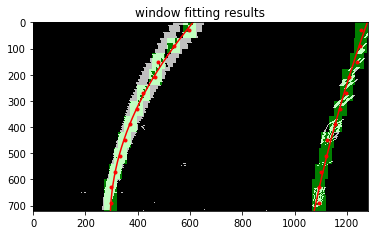

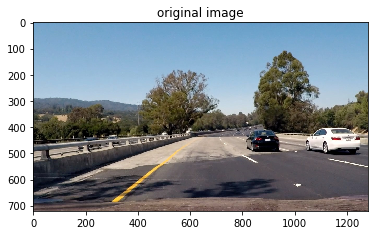

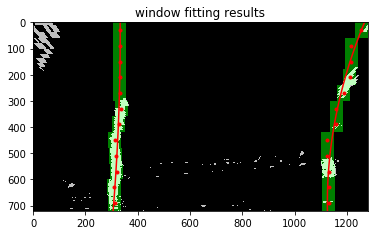

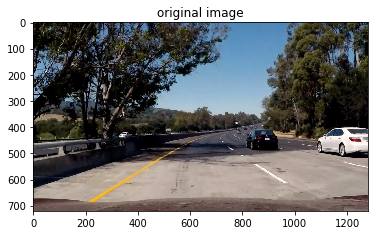

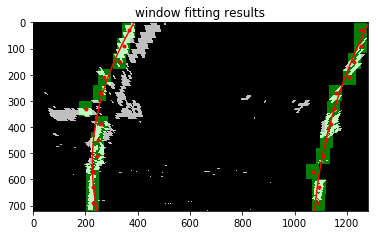

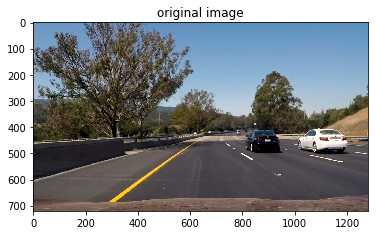

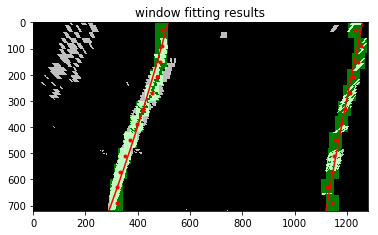

In [10]:
for i in range(8):
    # Read in a thresholded image
    img = cv2.imread(road_images[i])[:,:,::-1]
    warped = 255*warper(region_of_interest(combined_bin(img), vertices), src, dst)

    # window settings
    window_width = 50 
    window_height = 60 # Break image into 12 vertical layers since image height is 720
    margin = 60 # How much to slide left and right for searching

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, .75, template, 0.5, 0.0) # overlay the orignal road image with window results

        # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
    plt.figure()
    plt.imshow(img)
    plt.title('original image')
    plt.figure()
    plt.imshow(output)
    left, right = lane_points(window_centroids, imshape, window_height)
    for l,r in zip(left, right):
        plt.plot(l[0], l[1], 'r.')
        plt.plot(r[0], r[1], 'r.')
    left_fit, right_fit = fit_lanes(left, right)

    # Generate x and y values for plotting
    left_fitx, right_fitx, ploty = get_plot_data(warped, left_fit, right_fit)

    plt.plot(left_fitx, ploty, color='red')
    plt.plot(right_fitx, ploty, color='red')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    plt.title('window fitting results')
    plt.show()

## Curvature and Vehicle Postion

In [11]:
def calc_cr(lx, rx, y):
    # calculate curve radius at bottom of image
    y_eval = np.max(y)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 5/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(y*ym_per_pix, lx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(y*ym_per_pix, rx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    l_cr = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    r_cr = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    return l_cr, r_cr

def calc_vehicle_pos(lx, rx):
    # calculate the offset from center lane driving assuming a center mounted camera
    # convert from pixels to meters
    xm_per_pix = 5/700 # meters per pixel in x dimension
    pos = (1280 - (lx[-1] + rx[-1])) * xm_per_pix
    return pos

In [12]:
left_curverad, right_curverad = calc_cr(left_fitx, right_fitx, ploty)
pos = calc_vehicle_pos(left_fitx, right_fitx)
s_cr = 'Radius left: {:.1f} m'.format(left_curverad) + ', ' + 'Radius right: {:.1f} m'.format(right_curverad)
s_pos = 'Vehicle position offset: {:.1f} m'.format(pos)
print(s_cr)
print(s_pos)


Radius left: 1822.0 m, Radius right: 4452.1 m
Vehicle position offset: -0.9 m


## Output Visualization

In [13]:
def draw_lane_rect(img_, lx, rx, y):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img_).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    coords_left = np.transpose(np.stack((lx, y), axis=0))
    coords_right = np.transpose(np.stack((rx, y), axis=0))
    coords = np.concatenate((coords_left, np.flipud(coords_right))).astype(np.int32)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, [coords], color=(0,255,0))

    # Warp the blank back to original image space by swapping dst and src
    newwarp = warper(color_warp, dst, src) 

    # Combine the result with the original image
    result = cv2.addWeighted(cv2.undistort(img_, mtx, dist, None, None), 1, newwarp, 0.3, 0)
    
    return result

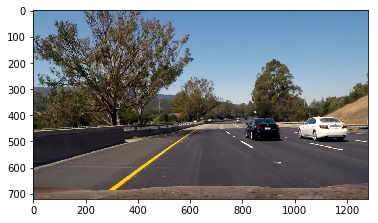

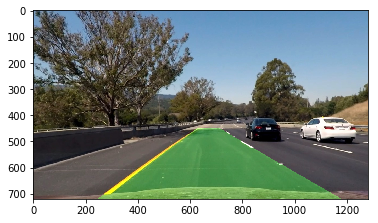

In [14]:
plt.imshow(img)

result = draw_lane_rect(img, left_fitx, right_fitx, ploty)

plt.figure()
plt.imshow(result)

## Video Pipeline

In [15]:
# Import everything needed to edit/save/watch video clips (P1)
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = np.array([0,0,0], dtype='float')
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [27]:
def process_image(img_in):
    
    global frame_counter, text_img
    global l_line, r_line
    
    # piece it all together
    
    # transform perspective
    img_ = 255*warper(region_of_interest(combined_bin(img_in), vertices), src, dst)
    
    # convolution lane detection
    centroids_ = find_window_centroids(img_, window_width, window_height, margin)
    
    # convert center x coordinate to (x,y) points and calculate polynomial
    l_p, r_p = lane_points(centroids_, imshape, window_height)
    l_fit, r_fit = fit_lanes(l_p, r_p)
    
    
    if l_line.detected:
        # check for lanes to start on their side and for jumps in the coefficients
        if l_fit[2] > imshape[1]*0.5 or abs(l_line.current_fit[2] - l_fit[2]) > 2*margin:
            l_fit = l_line.current_fit
        l_line.current_fit = 0.8 * l_line.current_fit + 0.2 * l_fit
    else: 
        l_line.current_fit = l_fit
        l_line.detected = True
    if r_line.detected:
        # check for lanes to start on their side and for jumps in the coefficients
        if r_fit[2] < imshape[1]*0.5 or abs(r_line.current_fit[2] - r_fit[2]) > 2*margin:
            r_fit = r_line.current_fit
        r_line.current_fit = 0.8 * r_line.current_fit + 0.2 * r_fit
    else: 
        r_line.current_fit = r_fit
        r_line.detected = True

    # Generate x and y values for plotting
    lx, rx, y_data = get_plot_data(img_, l_line.current_fit, r_line.current_fit)
    
    # write curve radii and vehicle postion to image
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    if 0 == frame_counter:
        left_curverad, right_curverad = calc_cr(lx, rx, y_data)
        pos = calc_vehicle_pos(lx, rx)
        s_cr = 'Radius left: {:.1f} m'.format(left_curverad) + ', ' + 'Radius right: {:.1f} m'.format(right_curverad)
        s_pos = 'Vehicle position offset: {:.1f} m'.format(pos)
        s_coeff_r = 'Polynomial coefficients right: {:.6f}, {:.3f}, {:.0f}'.format(*r_line.current_fit)
        s_coeff_l = 'Polynomial coefficients left: {:.6f}, {:.3f}, {:.0f}'.format(*l_line.current_fit)
        text_img = np.zeros_like(img_).astype(np.uint8)
        cv2.putText(text_img, s_cr, (50, 50), font, 1, (255, 255, 255), 3)
        cv2.putText(text_img, s_pos, (50, 90), font, 1, (255, 255, 255), 3)
        cv2.putText(text_img, s_coeff_r, (50, 130), font, 1, (255, 255, 255), 3)
        cv2.putText(text_img, s_coeff_l, (50, 170), font, 1, (255, 255, 255), 3)
        text_img = np.dstack((text_img, text_img, text_img))
    
    frame_counter = (frame_counter + 1) % 25

    # draw rectangle into lane and reverse perspective transform
    result = draw_lane_rect(img_in, lx, rx, y_data)
    
    result = cv2.addWeighted(result, 1, text_img, 1, 0)
    
    return result

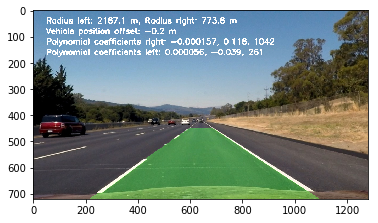

In [28]:
text_img = np.array([])
r_line, l_line = Line(), Line()
frame_counter = 0
img = cv2.imread(road_images[1])[:,:,::-1]
img = process_image(img)
plt.imshow(img)

In [29]:
text_img = np.array([])
r_line, l_line = Line(), Line()
frame_counter = 0
vid_out = 'vid_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip_out = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip_out.write_videofile(vid_out, audio=False)


[MoviePy] >>>> Building video vid_out.mp4
[MoviePy] Writing video vid_out.mp4


100%|█████████▉| 1260/1261 [06:03<00:00,  3.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vid_out.mp4 

Wall time: 6min 5s


In [30]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(vid_out))